In [4]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install wordcloud
!pip install geopy
!pip install folium
!pip install scikit-learn

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
!pip install openpyxl

In [8]:
# Load the dataset
file_path = 'IIT Roorkee Alumni Association Participation Survey  (Responses).xlsx'
df = pd.ExcelFile(file_path).parse('Form Responses 1')

In [9]:
# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('?', '').str.replace('.', '').str.lower()

In [10]:
# Convert 'year_of_graduation' to numeric (if not already)
df['year_of_graduation'] = pd.to_numeric(df['year_of_graduation'], errors='coerce')

# Keep only records where year_of_graduation is 2010 or later
df = df[df['year_of_graduation'] >= 2010]

# Reset index
df.reset_index(drop=True, inplace=True)

# Display the first few rows of the cleaned dataset
df.head()

,timestamp,email_address,name,year_of_graduation,course,are_you_aware_of_the_existence_of_iitr_alumni_association,are_you_a_member_of_iitr_alumni_association_,if_you've_answered_no_above_then__what_are_the_main_reasons_you_have_not_joined_the_alumni_group,how_do_you_usually_receive_information_about_alumni_activities_or_groups,what_type_of_activities_or_benefits_would_encourage_you_to_join_the_alumni_group,what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches,where_are_you_currently_living_(_city-state-country)
0,2025-01-03 13:10:25.468,kanishka.mohan@gmail.com,Kanishka Mohan,2010,B.Tech (Bachelor of Technology),Yes,Yes,NaN,Local Chapter in city,Networking opportunities,Print a coffee table of the 175th anniversary ...,"Bangalore, Karnataka, India"
1,2025-01-03 13:20:33.469,vijay824110@gmail.com,Vijay Khandelwal,2010,M.Tech (Master of Technology),Yes,Yes,NaN,Email,Career development sessions,Having batch wise and/or deptt wise social med...,Chandigarh India
2,2025-01-03 13:48:13.530,manish.lila@gmail.com,Dr. Manish Kumar Lila,2019,Ph.D. (Doctor of Philosophy),Yes,Yes,NaN,Email,Reunions and social events,"Support for business, networking and funding o...",Dehradun
3,2025-01-03 13:50:28.982,leojohns2012@gmail.com,Leo Johns,2015,B.Tech (Bachelor of Technology),Yes,Yes,NaN,Email,Networking opportunities,Make a larger org. Recruit from external corpo...,London-UK
4,2025-01-03 13:50:36.305,viraj20feb@gmail.com,Viraj Belekar,2015,B.Tech (Bachelor of Technology),No,Yes,NaN,Email,Reunions and social events,Clear emails/posts about reunions. It would be...,San Diego-California-USA


In [11]:
# Handle missing values
df['if_you\'ve_answered_no_above_then__what_are_the_main_reasons_you_have_not_joined_the_alumni_group'] = df['if_you\'ve_answered_no_above_then__what_are_the_main_reasons_you_have_not_joined_the_alumni_group'].fillna('No response')
df['what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches'] = df['what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches'].fillna('No suggestion')
df['where_are_you_currently_living_(_city-state-country)'] = df['where_are_you_currently_living_(_city-state-country)'].fillna('Unknown')


In [12]:


# Ensure 'Location_Cleaned' column exists by copying data from the original location column
if "Location_Cleaned" not in df.columns:
    df["Location_Cleaned"] = df["where_are_you_currently_living_(_city-state-country)"].astype(str)

# Convert all locations to lowercase and strip spaces
df["Location_Cleaned"] = df["Location_Cleaned"].str.lower().str.strip()

# Replace multiple delimiters like "-", "," with a single space
df["Location_Cleaned"] = df["Location_Cleaned"].apply(lambda x: re.sub(r"[-,]", " ", x))

# Replace multiple spaces with a single space
df["Location_Cleaned"] = df["Location_Cleaned"].apply(lambda x: re.sub(r"\s+", " ", x))

# Standardization mappings
standard_location_mapping = {
    "bangalore": ["bengaluru karnataka india", "bengaluru india", "bangalore karnataka india", "bangluru", "bengaluru"],
    "delhi": ["delhi delhi india", "new delhi india", "delhi india", "new delhi", "delhi-india"],
    "gurgaon": ["gurgaon haryana india", "gurugram haryana india", "gurgaon haryana"],
    "mumbai": ["mumbai maharashtra india", "mumbai - maharashtra - india"],
    "pune": ["pune maharashtra india", "pune maharashtra"],
    "faridabad": ["faridabad haryana india", "faridabad haryana"],
    "hyderabad": ["hyderabad telangana india"],
    "chandigarh": ["chandigarh india"],
    "chennai": ["chennai tamil nadu india", "chennai tamil nadu"],
    "ahmedabad": ["ahmedabad gujrat india", "ahemdabad", "ahmedabad- gujrat- india"],
    "dehradun": ["dehradun uttarakhand india", "dehradun-uttarakhand-india"],
    "lucknow": ["lucknow uttar pradesh india", "lucknow-uttar pradesh-india"],
    "london": ["london uk", "london united kingdom", "london-uk"],
    "noida": ["noida india", "noida - india"]
}

# Apply the mappings
for standardized_location, variations in standard_location_mapping.items():
    df.loc[df["Location_Cleaned"].isin(variations), "Location_Cleaned"] = standardized_location

# Display cleaned locations
print(df["Location_Cleaned"].value_counts())

Location_Cleaned
bangalore                                     20
delhi                                          8
gurgaon                                        7
mumbai                                         4
pune                                           3
chandigarh                                     3
dehradun                                       3
london                                         2
chennai                                        2
noida                                          2
hyderabad                                      2
ahmedabad                                      2
faridabad                                      2
lucknow                                        2
toronto ontario canada                         1
aligarh muslim university aligarh up india     1
tehri garhwal                                  1
gainesville florida usa                        1
karauli rajasthan india                        1
faridabad(haryana)                             1
kar

In [13]:
print(df['are_you_a_member_of_iitr_alumni_association_'].unique())

['Yes' 'No']


Years with lowest membership penetration:
                     % Not a Member
year_of_graduation                
2020                    100.000000
2021                    100.000000
2024                     63.636364
2022                     57.142857
2023                     53.333333


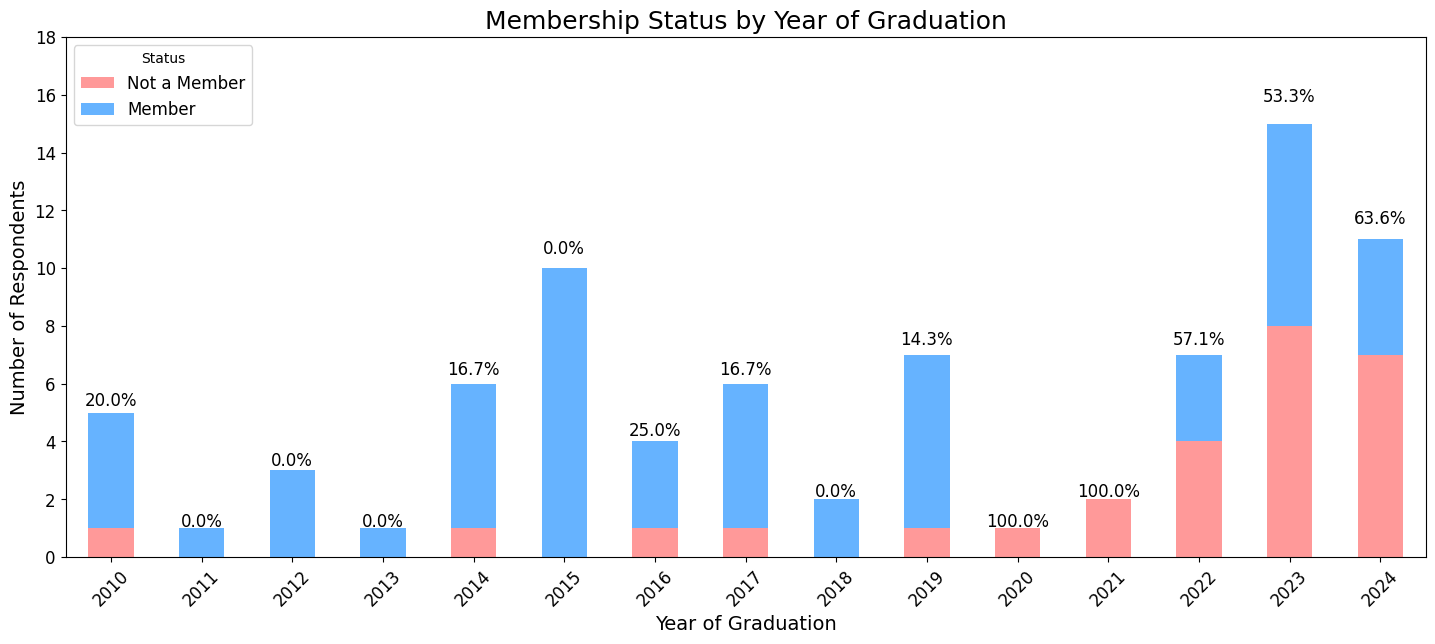

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by graduation year and membership status
membership_by_year = df.groupby(['year_of_graduation', 'are_you_a_member_of_iitr_alumni_association_']).size().unstack(fill_value=0)

# Rename columns for better readability
membership_by_year.columns = ["Not a Member", "Member"]

# Add a total column
membership_by_year["Total"] = membership_by_year["Not a Member"] + membership_by_year["Member"]

# Calculate percentage of "Not a Member"
membership_by_year["% Not a Member"] = (membership_by_year["Not a Member"] / membership_by_year["Total"]) * 100

# Identify years with lowest membership penetration (>50% Not a Member)
low_penetration = membership_by_year[membership_by_year["% Not a Member"] > 50]
print("Years with lowest membership penetration:\n",
      low_penetration[["% Not a Member"]].sort_values(by="% Not a Member", ascending=False))

# Adjust figure size for better readability
fig, ax = plt.subplots(figsize=(16, 8))

# Plot stacked bar chart
membership_by_year[["Not a Member", "Member"]].plot(
    kind='bar', stacked=True, color=['#FF9999', '#66B3FF'], ax=ax
)

# Set y-axis limit slightly above the maximum value
ax.set_ylim(0, membership_by_year["Total"].max() * 1.2)  # Increase by 20% for padding

# Add percentage labels within bounds
for i, (total, pct_non_member) in enumerate(zip(membership_by_year["Total"], membership_by_year["% Not a Member"])):
    ax.text(i, total * 1.05, f"{pct_non_member:.1f}%", 
            ha='center', fontsize=12, color='black', clip_on=True)  # Keep inside bounds

# Titles and labels
plt.title('Membership Status by Year of Graduation', fontsize=18)
plt.xlabel('Year of Graduation', fontsize=14)
plt.ylabel('Number of Respondents', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Not a Member', 'Member'], title="Status", fontsize=12)

# Adjust layout for better visibility
plt.subplots_adjust(top=0.85, bottom=0.2, left=0.1, right=0.95)  # Adjusted top margin

plt.show()


C:\Users\Nandan\AppData\Local\Temp\ipykernel_26668\1165746634.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=non_member_reasons.index, x=non_member_reasons.values, palette='viridis')


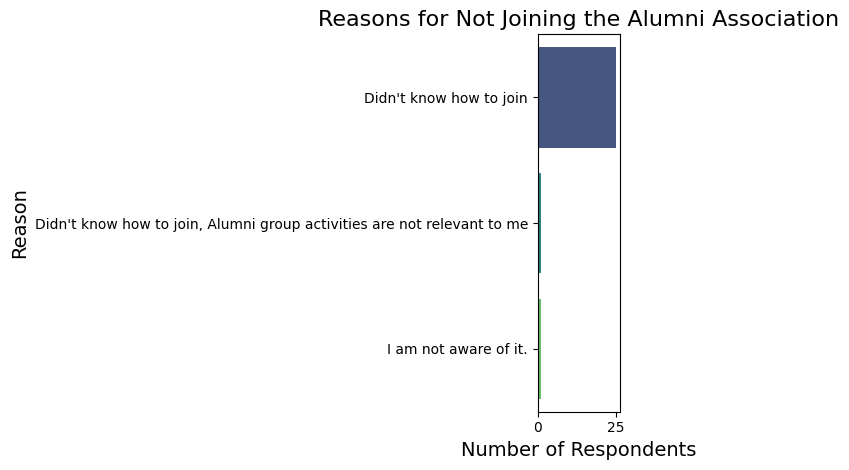

In [15]:
# Visualization 2: Reasons for not joining (Bar Chart)
non_member_reasons = df[df['are_you_a_member_of_iitr_alumni_association_'] == 'No']['if_you\'ve_answered_no_above_then__what_are_the_main_reasons_you_have_not_joined_the_alumni_group'].value_counts()
sns.barplot(y=non_member_reasons.index, x=non_member_reasons.values, palette='viridis')
plt.title('Reasons for Not Joining the Alumni Association', fontsize=16)
plt.xlabel('Number of Respondents', fontsize=14)
plt.ylabel('Reason', fontsize=14)
plt.tight_layout()
plt.show()


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset index for easier plotting
reason_by_year_reset = reason_by_year.reset_index().melt(id_vars=['year_of_graduation'], var_name='Reason', value_name='Count')

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=reason_by_year_reset, x='year_of_graduation', y='Count', hue='Reason', palette='viridis')

plt.title('Reasons for Not Joining the Alumni Association by Graduation Year', fontsize=16)
plt.xlabel('Year of Graduation', fontsize=14)
plt.ylabel('Number of Respondents', fontsize=14)
plt.legend(title="Reason", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


NameError: name 'reason_by_year' is not defined

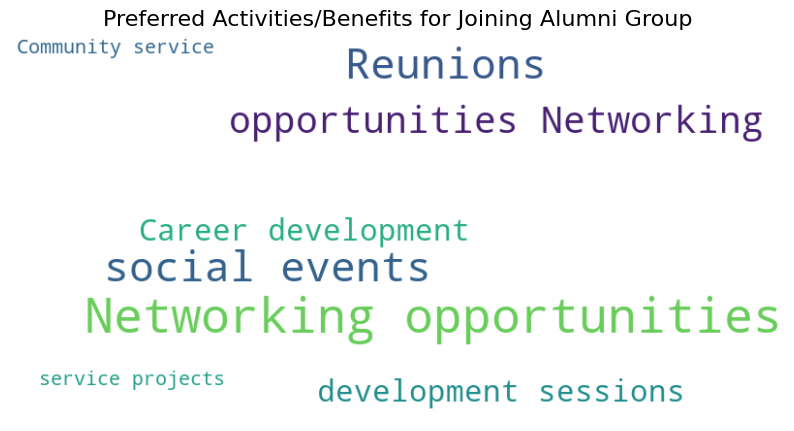

In [17]:
# Visualization 3: Preferred activities/benefits (Word Cloud)
activities_text = ' '.join(df['what_type_of_activities_or_benefits_would_encourage_you_to_join_the_alumni_group'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(activities_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Preferred Activities/Benefits for Joining Alumni Group', fontsize=16)
plt.show()

Top 3 Preferred Activities: [('networking', 37), ('opportunities', 37), ('reunions', 26)]


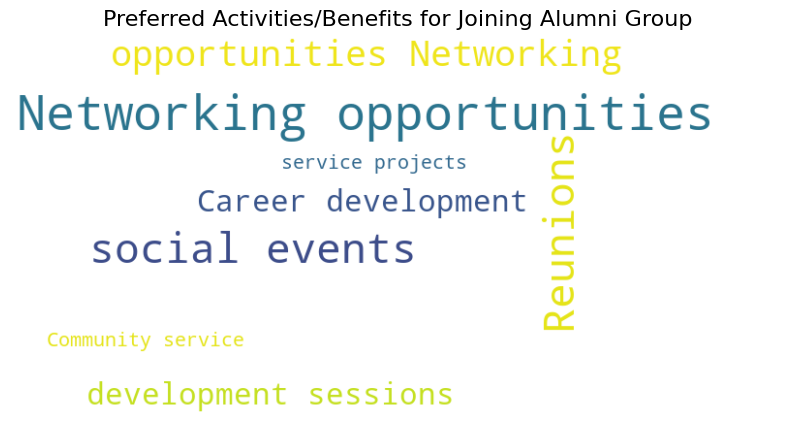

In [18]:
from collections import Counter
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
activities_text = ' '.join(df['what_type_of_activities_or_benefits_would_encourage_you_to_join_the_alumni_group'])

# Count word frequencies
words = activities_text.lower().split()  # Convert to lowercase and split words
word_counts = Counter(words)

# Get the top 3 most common words
top_3_activities = word_counts.most_common(3)
print("Top 3 Preferred Activities:", top_3_activities)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(activities_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Preferred Activities/Benefits for Joining Alumni Group', fontsize=16)
plt.show()

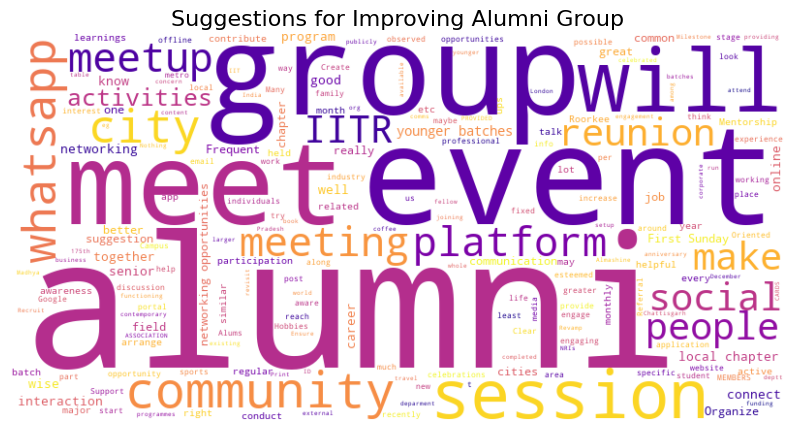

In [19]:
# Visualization 4: Suggestions for improvement (Word Cloud)
suggestions_text = ' '.join(df['what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(suggestions_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Suggestions for Improving Alumni Group', fontsize=16)
plt.show()

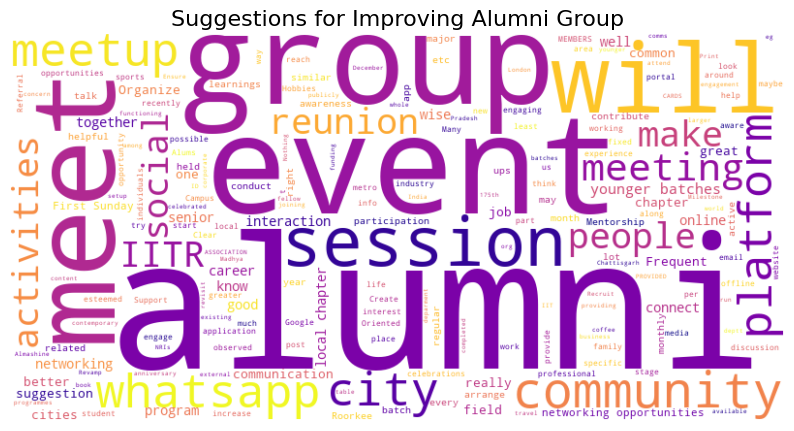

In [20]:
# Combine all suggestions into one text
suggestions_text = ' '.join(df['what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches'])

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(suggestions_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Suggestions for Improving Alumni Group', fontsize=16)
plt.show()

In [21]:
import pandas as pd

# Group suggestions by Graduation Year and Location
grouped_suggestions = df.groupby(["year_of_graduation", "Location_Cleaned"])["what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches"].apply(lambda x: ' '.join(x)).reset_index()

# Display the first few rows
print(grouped_suggestions.head(10))


   year_of_graduation                            Location_Cleaned  \
0                2010                                   bangalore   
1                2010                                  chandigarh   
2                2010                                       delhi   
3                2011                                     chennai   
4                2012  aligarh muslim university aligarh up india   
5                2012                                   bangalore   
6                2012                      toronto ontario canada   
7                2013                                   ahmedabad   
8                2014                                   bangalore   
9                2014                                       delhi   

  what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches  
0  Print a coffee table of the 175th anniversary ...                                                         

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nandan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Columns in DataFrame: Index(['timestamp', 'email_address', 'name', 'year_of_graduation', 'course',
       'are_you_aware_of_the_existence_of_iitr_alumni_association',
       'are_you_a_member_of_iitr_alumni_association_',
       'if_you've_answered_no_above_then__what_are_the_main_reasons_you_have_not_joined_the_alumni_group',
       'how_do_you_usually_receive_information_about_alumni_activities_or_groups',
       'what_type_of_activities_or_benefits_would_encourage_you_to_join_the_alumni_group',
       'what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches',
       'where_are_you_currently_living_(_city-state-country)',
       'Location_Cleaned'],
      dtype='object')
Columns in exploded_suggestions: Index(['year_of_graduation', 'Location_Cleaned', 'cleaned_suggestions',
       'Top_Words', 'Word', 'Frequency'],
      dtype='object')


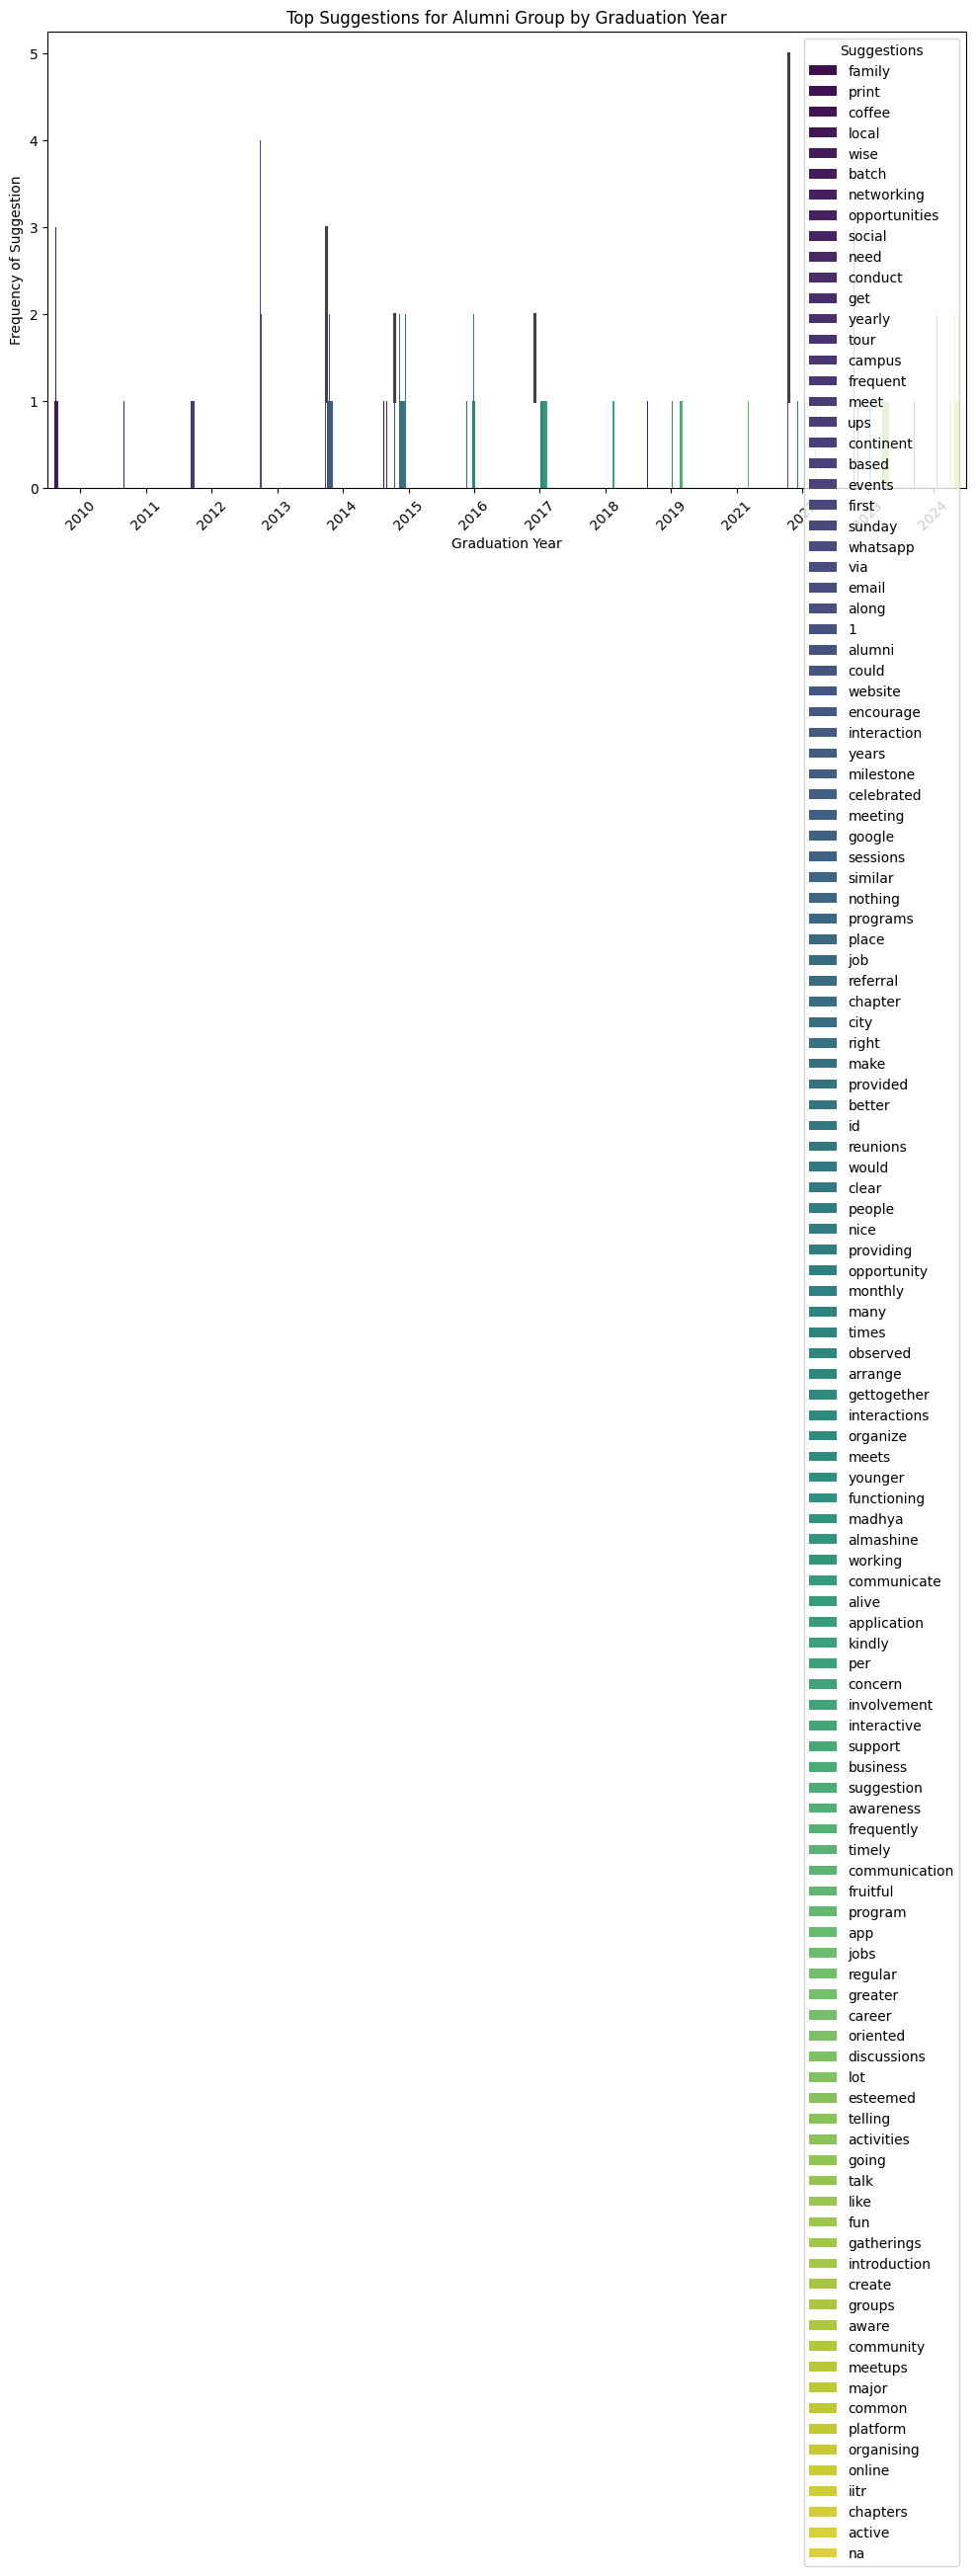

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not available
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return " ".join(words)

# Check column names
print("Columns in DataFrame:", df.columns)

# Apply text cleaning
df["cleaned_suggestions"] = df["what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches"].astype(str).apply(clean_text)

# Group by Year of Graduation & Location, then concatenate cleaned suggestions
grouped_suggestions = df.groupby(["year_of_graduation", "Location_Cleaned"])["cleaned_suggestions"].apply(lambda x: ' '.join(x)).reset_index()

# Ensure year_of_graduation is properly formatted
grouped_suggestions["year_of_graduation"] = grouped_suggestions["year_of_graduation"].astype(str)

# Tokenize words and get top 3 words per group
def extract_top_words(text):
    words = text.split()
    common_words = Counter(words).most_common(3)  # Get top 3 words
    return [(word, freq) for word, freq in common_words]

grouped_suggestions["Top_Words"] = grouped_suggestions["cleaned_suggestions"].apply(extract_top_words)

# Explode into multiple rows
exploded_suggestions = grouped_suggestions.explode("Top_Words")

# Extract words and frequency
exploded_suggestions["Word"] = exploded_suggestions["Top_Words"].apply(lambda x: x[0] if isinstance(x, tuple) else None)
exploded_suggestions["Frequency"] = exploded_suggestions["Top_Words"].apply(lambda x: x[1] if isinstance(x, tuple) else None)

# Drop NaN values
exploded_suggestions = exploded_suggestions.dropna(subset=["Word"])

# **Debugging Step**: Print to verify columns
print("Columns in exploded_suggestions:", exploded_suggestions.columns)

# Plot Top Suggestions by Year of Graduation
plt.figure(figsize=(12, 6))
sns.barplot(data=exploded_suggestions, x="year_of_graduation", y="Frequency", hue="Word", palette="viridis")
plt.xticks(rotation=45)
plt.title("Top Suggestions for Alumni Group by Graduation Year")
plt.xlabel("Graduation Year")
plt.ylabel("Frequency of Suggestion")
plt.legend(title="Suggestions", loc="upper right")
plt.show()


C:\Users\Nandan\AppData\Local\Temp\ipykernel_26668\966866474.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=locations.index, x=locations.values, palette='coolwarm', orient="h")


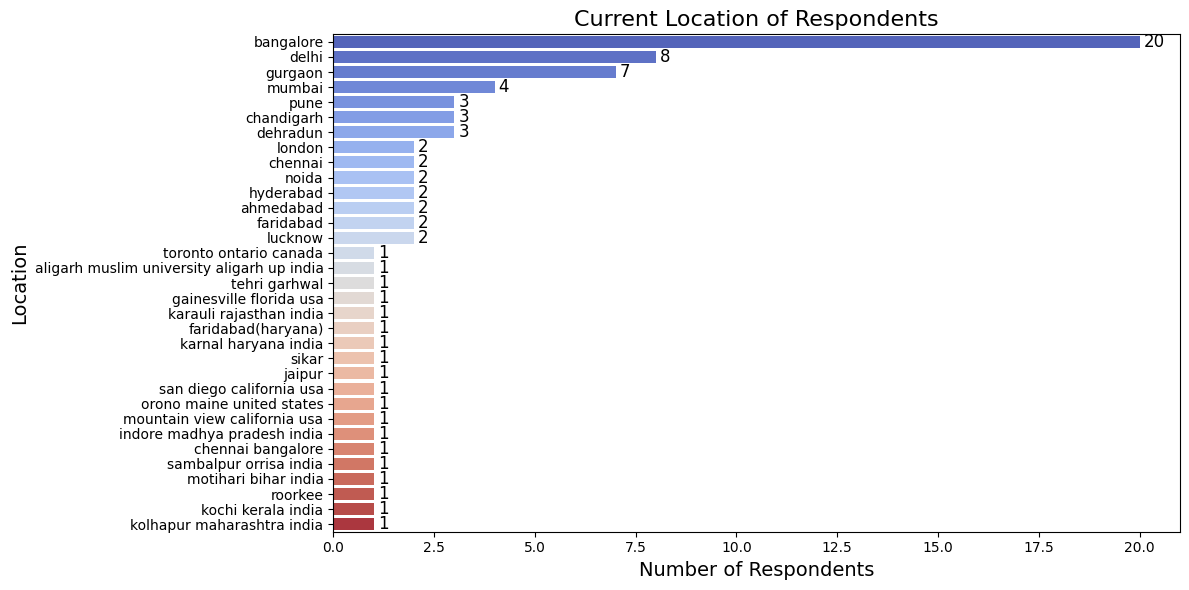

In [24]:
# Count occurrences of each location
locations = df["Location_Cleaned"].value_counts()

# Set figure size for better readability
plt.figure(figsize=(12, 6))

# Create horizontal bar chart with color gradient
sns.barplot(y=locations.index, x=locations.values, palette='coolwarm', orient="h")

# Add labels and title
plt.title('Current Location of Respondents', fontsize=16)
plt.xlabel('Number of Respondents', fontsize=14)
plt.ylabel('Location', fontsize=14)

# Add value labels to each bar
for index, value in enumerate(locations.values):
    plt.text(value + 0.1, index, str(value), va='center', fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()

In [ ]:
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster

In [26]:
import folium
from geopy.geocoders import Nominatim
from folium.plugins import MarkerCluster

# Handle missing values for location
df['Location_Cleaned'] = df['Location_Cleaned'].fillna('Unknown')

# Extract unique locations
locations = df['Location_Cleaned'].value_counts().reset_index()
locations.columns = ['location', 'count']

# Geocode locations (convert city-state-country to latitude and longitude)
geolocator = Nominatim(user_agent="geoanalysis")
locations['coordinates'] = locations['location'].apply(lambda loc: geolocator.geocode(loc, timeout=10) if loc != 'Unknown' else None)
locations['latitude'] = locations['coordinates'].apply(lambda x: x.latitude if x else None)
locations['longitude'] = locations['coordinates'].apply(lambda x: x.longitude if x else None)

# Filter valid locations
valid_locations = locations.dropna(subset=['latitude', 'longitude'])

# Create a world map
world_map = folium.Map(location=[20, 0], zoom_start=2)

# Add marker clusters
marker_cluster = MarkerCluster().add_to(world_map)

for _, row in valid_locations.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=f"{row['location']}: {row['count']} respondents"
    ).add_to(marker_cluster)

# Display the map in the notebook
world_map


In [ ]:
from wordcloud import WordCloud
from textblob import TextBlob

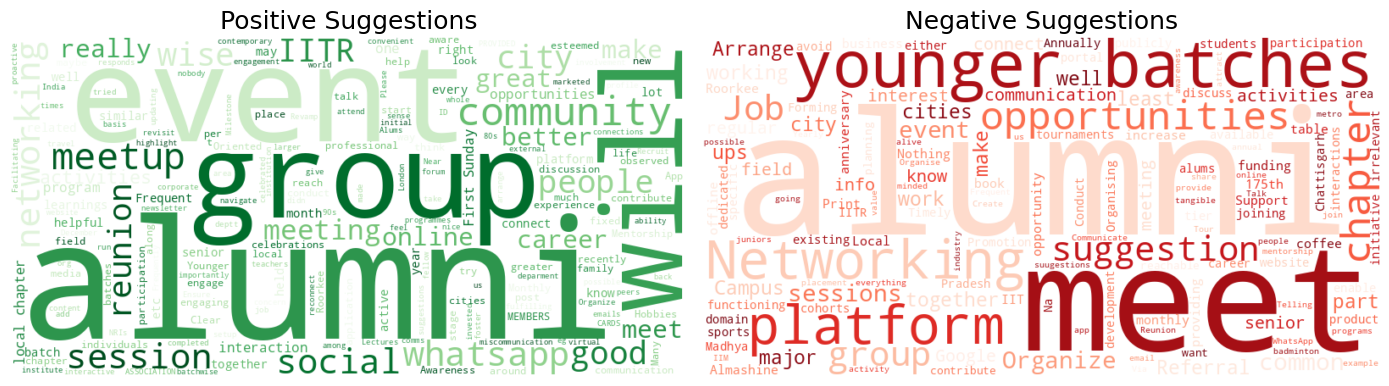

In [ ]:
# Classify suggestions into positive and negative using TextBlob sentiment polarity
def classify_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    return 'Positive' if sentiment > 0 else 'Negative'

df['sentiment'] = df['what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches'].apply(classify_sentiment)

# Separate positive and negative suggestions
positive_suggestions = ' '.join(df[df['sentiment'] == 'Positive']['what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches'])
negative_suggestions = ' '.join(df[df['sentiment'] == 'Negative']['what_improvements_would_you_suggest_to_make_the_alumni_group_more_appealing_and_drive_greater_participation_of_younger_batches'])

# Generate word clouds
plt.figure(figsize=(14, 7))

# Positive Word Cloud
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_suggestions)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Suggestions', fontsize=18)

# Negative Word Cloud
plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_suggestions)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Suggestions', fontsize=18)

plt.tight_layout()
plt.show()

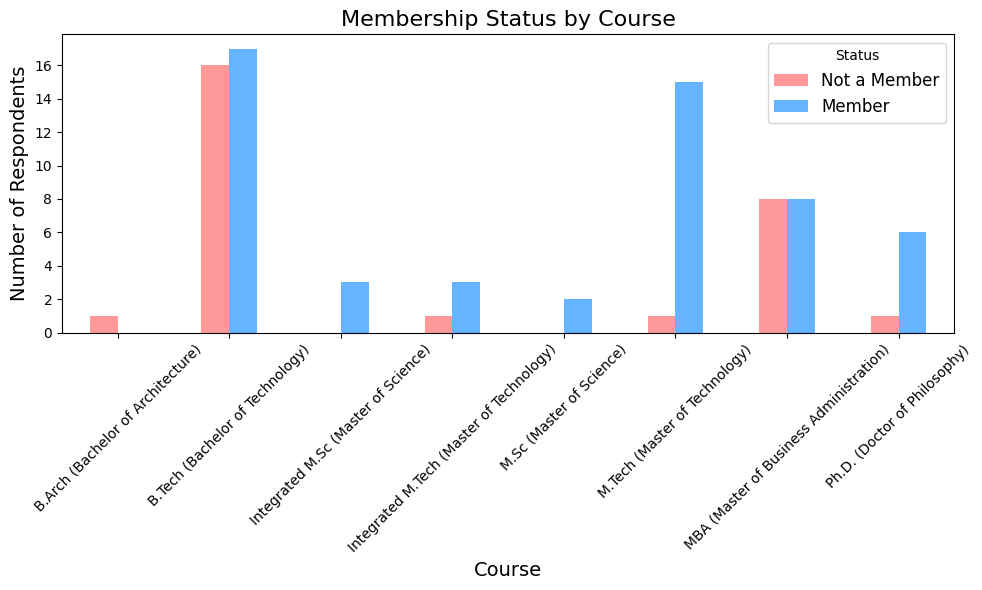

In [ ]:
# Membership by course
course_membership = df.groupby(['course', 'are_you_a_member_of_iitr_alumni_association_']).size().unstack(fill_value=0)

# Grouped bar chart
course_membership.plot(kind='bar', figsize=(10, 6), color=['#FF9999', '#66B3FF'])
plt.title('Membership Status by Course', fontsize=16)
plt.xlabel('Course', fontsize=14)
plt.ylabel('Number of Respondents', fontsize=14)
plt.xticks(rotation=45)
plt.legend(['Not a Member', 'Member'], title="Status", fontsize=12)
plt.tight_layout()
plt.show()

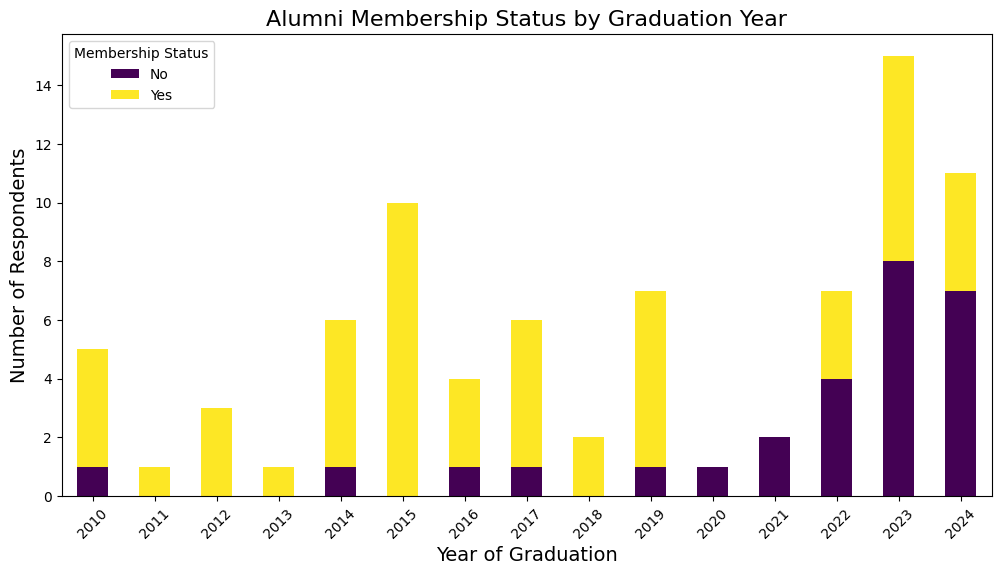

In [27]:
import matplotlib.pyplot as plt

# Get membership data
grad_year_membership = df.groupby(['year_of_graduation', 'are_you_a_member_of_iitr_alumni_association_']).size().unstack(fill_value=0)

# Plot stacked bar chart
grad_year_membership.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')

# Labels and title
plt.title('Alumni Membership Status by Graduation Year', fontsize=16)
plt.xlabel('Year of Graduation', fontsize=14)
plt.ylabel('Number of Respondents', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Membership Status", labels=['No', 'Yes'])

# Show plot
plt.show()


In [31]:
import pandas as pd

# Sample DataFrame (Replace this with your actual data)
data = {
    "Location_Cleaned": [
        "Bangalore", "Bangalore", "Mumbai", "Delhi", "Delhi", "Hyderabad", "Mumbai"
    ],
    "year_of_graduation": [2015, 2018, 2012, 2017, 2020, 2019, 2016],
    "are_you_a_member_of_iitr_alumni_association_": ["No", "Yes", "No", "Yes", "No", "Yes", "No"]
}

df = pd.DataFrame(data)

# Define Recommendations Based on Location
recommendations = {
    "Bangalore": "Organize monthly tech and startup networking events.",
    "Mumbai": "Host finance and consulting roundtables for alumni.",
    "Delhi": "Strengthen mentorship programs with government and policy experts.",
    "Hyderabad": "Launch workshops on AI, cloud computing, and entrepreneurship.",
    "Unknown": "Encourage virtual networking and global webinars."
}

# Map Recommendations Based on Alumni Location
df["Recommendations"] = df["Location_Cleaned"].map(lambda loc: recommendations.get(loc, "Encourage online engagement."))

# Display Recommendations by Location
recommendations_by_location = df.groupby("Location_Cleaned")["Recommendations"].unique()
print(recommendations_by_location)

# Convert to a DataFrame for better visualization
recommendation_df = recommendations_by_location.reset_index()
print(recommendation_df)


Location_Cleaned
Bangalore    [Organize monthly tech and startup networking ...
Delhi        [Strengthen mentorship programs with governmen...
Hyderabad    [Launch workshops on AI, cloud computing, and ...
Mumbai       [Host finance and consulting roundtables for a...
Name: Recommendations, dtype: object
  Location_Cleaned                                    Recommendations
0        Bangalore  [Organize monthly tech and startup networking ...
1            Delhi  [Strengthen mentorship programs with governmen...
2        Hyderabad  [Launch workshops on AI, cloud computing, and ...
3           Mumbai  [Host finance and consulting roundtables for a...


C:\Users\Nandan\AppData\Local\Temp\ipykernel_26668\3134389143.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=values, y=labels, palette="Blues_r")


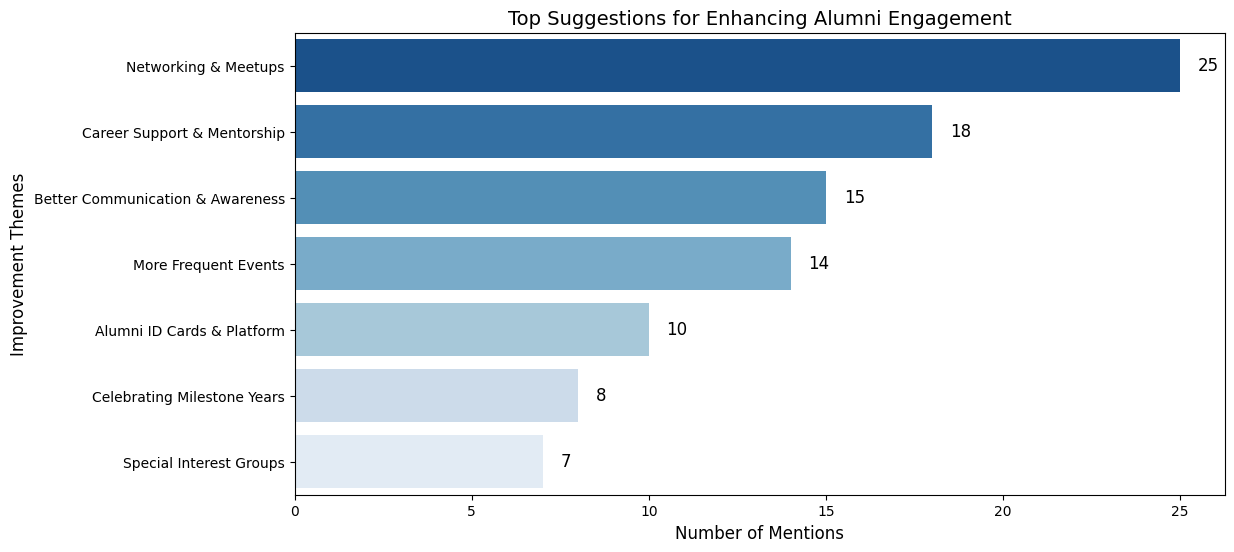

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Key themes with their approximate frequencies (based on extracted suggestions)
themes = {
    "Networking & Meetups": 25,
    "Career Support & Mentorship": 18,
    "Better Communication & Awareness": 15,
    "More Frequent Events": 14,
    "Alumni ID Cards & Platform": 10,
    "Celebrating Milestone Years": 8,
    "Special Interest Groups": 7
}

# Convert to lists for plotting
labels = list(themes.keys())
values = list(themes.values())

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=values, y=labels, palette="Blues_r")

# Titles & Labels
plt.xlabel("Number of Mentions", fontsize=12)
plt.ylabel("Improvement Themes", fontsize=12)
plt.title("Top Suggestions for Enhancing Alumni Engagement", fontsize=14)

# Display Values on Bars
for index, value in enumerate(values):
    plt.text(value + 0.5, index, str(value), va='center', fontsize=12, color="black")

plt.show()


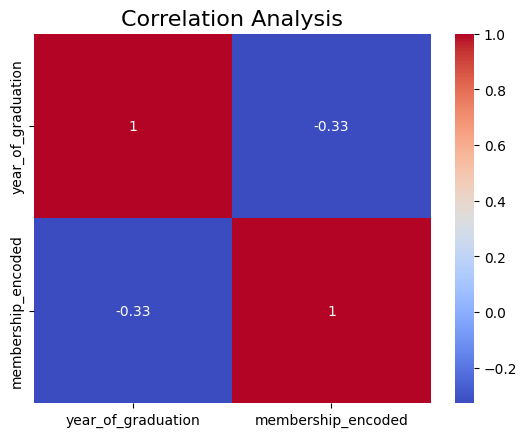

In [ ]:
# Encode membership status for correlation analysis
df['membership_encoded'] = df['are_you_a_member_of_iitr_alumni_association_'].apply(lambda x: 1 if x == 'Yes' else 0)

# Correlation matrix
correlation_matrix = df[['year_of_graduation', 'membership_encoded']].corr()

# Heatmap of correlations
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis', fontsize=16)
plt.show()

In [ ]:
# Information sources
info_sources = df['how_do_you_usually_receive_information_about_alumni_activities_or_groups_'].value_counts()

# Pie chart
info_sources.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), startangle=90, colors=sns.color_palette('pastel'))
plt.title('Information Sources for Alumni Activities', fontsize=16)
plt.ylabel('')  # Remove default y-axis label
plt.tight_layout()
plt.show()

KeyError: 'how_do_you_usually_receive_information_about_alumni_activities_or_groups_'

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = df[['year_of_graduation', 'membership_encoded']].dropna()

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply K-means
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Scatter plot of clusters
sns.scatterplot(x=features['year_of_graduation'], y=features['membership_encoded'], hue=df['cluster'], palette='Set2')
plt.title('K-means Clustering of Alumni', fontsize=16)
plt.xlabel('Year of Graduation', fontsize=14)
plt.ylabel('Membership Status (Encoded)', fontsize=14)
plt.legend(title='Cluster')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Features and target
X = df[['year_of_graduation']].dropna()
y = df['membership_encoded'].dropna()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')